In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import math
from collections import defaultdict
from sklearn.cluster import DBSCAN

In [27]:
def define_roi(img, max_display_size=800, window_name="Select ROI"):
    """
    Displays a resizable window for ROI selection, then returns the cropped ROI from the original image.

    Parameters:
    - img: np.ndarray, the original image
    - max_display_size: int, maximum width or height to resize image for display (default: 800)
    - window_name: str, name of the selection window

    Returns:
    - cropped_img: np.ndarray, the cropped region of interest from the original image
    - (x, y, w, h): tuple of ROI coordinates in the original image
    """
    orig_h, orig_w = img.shape[:2]
    scale = min(max_display_size / orig_w, max_display_size / orig_h, 1.0)

    # Resize image for easier selection
    resized_w, resized_h = int(orig_w * scale), int(orig_h * scale)
    resized_image = cv2.resize(img, (resized_w, resized_h))

    # Let user select ROI
    roi = cv2.selectROI(window_name, resized_image, showCrosshair=True, fromCenter=False)
    cv2.destroyAllWindows()

    # Convert ROI coordinates back to original scale
    x, y, w, h = roi
    x = int(x / scale)
    y = int(y / scale)
    w = int(w / scale)
    h = int(h / scale)

    cropped_img = img[y:y+h, x:x+w]
    return cropped_img, (x, y, w, h)

def hist_equalize(img):
    '''
    Histogram equalization for grayscale or color images.
    '''
    if len(img.shape) == 2:
        equalized_img = cv2.equalizeHist(img)
    else:
        channels = cv2.split(img)
        equalized_channels = [cv2.equalizeHist(ch) for ch in channels]
        equalized_img = cv2.merge(equalized_channels)

    return equalized_img

def preprocess_img(img, ksize=5, canny_low_thresh=30, canny_up_thresh=100):
    '''
    Convert to gray, equalize histogram, denoise using Gaussian, and detect edges
    before finding the outlines.
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = hist_equalize(gray)
    # blur = cv2.GaussianBlur(equalized, (ksize, ksize), 0)
    blur = cv2.bilateralFilter(equalized, d=5, sigmaColor=15, sigmaSpace=10) # avoids blurring the edges
    edges = cv2.Canny(blur, canny_low_thresh, canny_up_thresh)
    
    return edges

In [52]:
def group_by_row(contours):
    grouped = defaultdict(list)  # maps y -> list of (x, y)

    for c in contours:
        for point in c:
            x, y = point[0]
            grouped[y].append((x, y))

    # Sort each row's points by x
    grouped_sorted = []
    for y in sorted(grouped.keys()):
        row = sorted(grouped[y], key=lambda pt: pt[0])
        grouped_sorted.append(row)

    return grouped_sorted

def get_contours(edge):
    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return group_by_row(contours)

In [53]:
def get_cluster_centers(X, labels, unique_labels):
    cluster_centers = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        center = cluster_points.mean(axis=0)
        cluster_centers.append(center)
    return np.array(cluster_centers)

def dbscan_clustering(data, eps=2.0, min_samples=5):
    X = np.array(data)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_

    unique_labels = set(labels)
    unique_labels.discard(-1)

    cluster_centers = get_cluster_centers(X, labels, unique_labels)
    return X, labels, cluster_centers

def evaluate_cluster():
    pass

def filter_contours():
    pass

In [58]:
# img_path = "../images/hand2.jpg"
img_path = "segmented_clay.png"
img = cv2.imread(img_path)

# Obtain region of interest (ROI)
cropped_img, roi_points = define_roi(img)
img_edges = preprocess_img(cropped_img)
contours = get_contours(img_edges)

In [56]:
def plot_DBSCAN(rows):
    all_points = []
    all_labels = []
    all_centers = []

    for row in rows:
        X, labels, centers = dbscan_clustering(row, eps=3.0, min_samples=3)
        all_points.append(X)
        all_labels.append(labels)
        if centers.ndim == 2 and centers.shape[0] > 0:
            all_centers.append(centers)

    # Flatten data
    all_points = np.vstack(all_points)
    all_labels = np.concatenate(all_labels)
    all_centers = np.vstack(all_centers) if all_centers else np.empty((0, 2))

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.scatter(all_points[:, 0], all_points[:, 1], c=all_labels, cmap='viridis', s=10, label='Points')
    if all_centers.shape[0] > 0:
        plt.scatter(all_centers[:, 0], all_centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')

    plt.gca().invert_yaxis()
    plt.yticks(np.arange(int(all_points[:, 1].min()), int(all_points[:, 1].max()) + 1, 1))
    plt.title("DBSCAN Clustering Across All Rows")
    plt.legend()
    plt.tight_layout()
    plt.show()

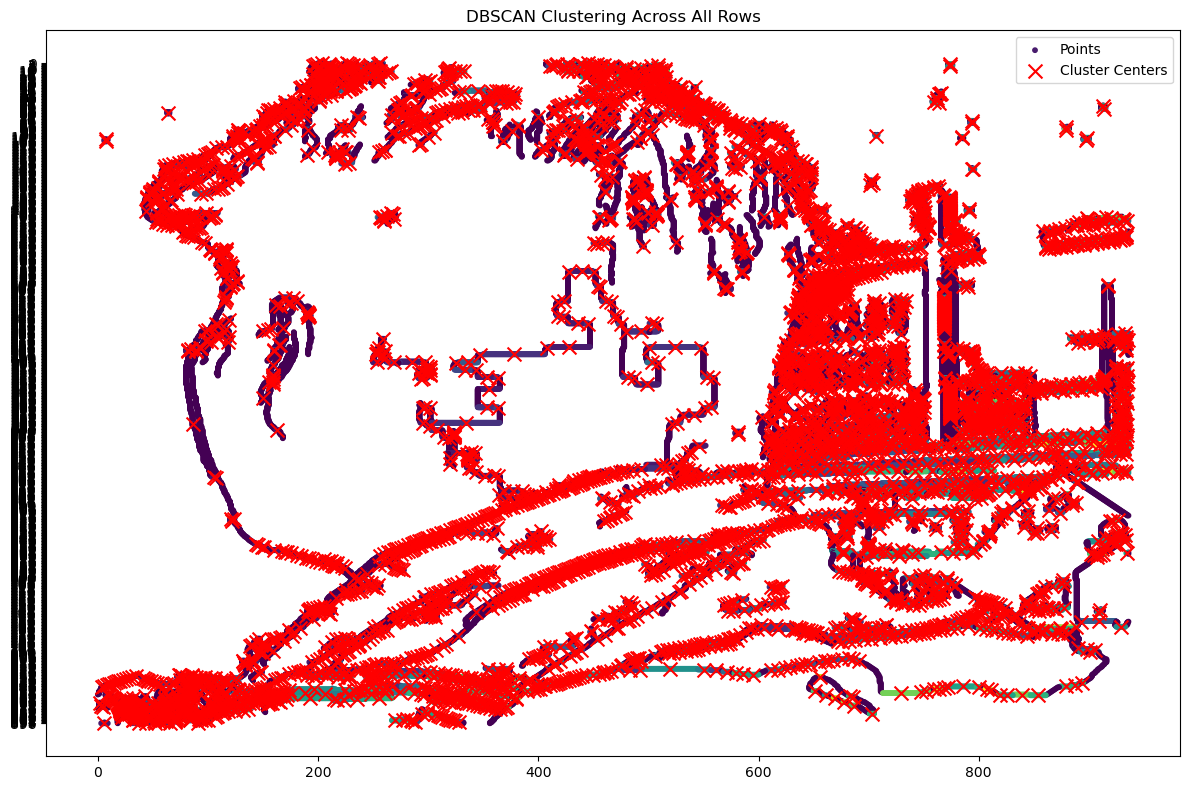

In [59]:
rows = [row1, row2, row3, row4, row5, row6, row7]
plot_DBSCAN(contours)

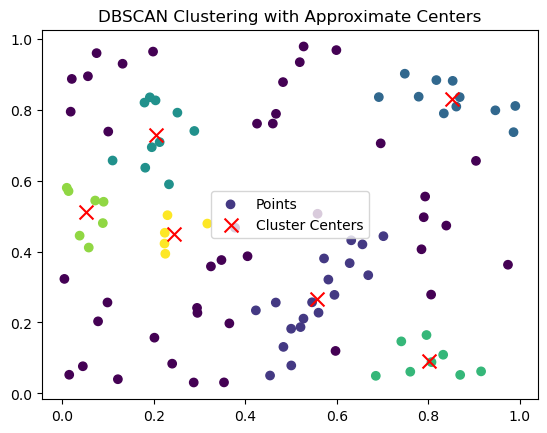

In [2]:
# Example data
X = np.random.rand(100, 2)

# DBSCAN clustering
db = DBSCAN(eps=0.1, min_samples=5).fit(X)
labels = db.labels_

# Get unique cluster labels (excluding noise: label == -1)
unique_labels = set(labels)
unique_labels.discard(-1)  # remove noise label

# Compute cluster centers as mean of points in each cluster
cluster_centers = []
for label in unique_labels:
    cluster_points = X[labels == label]
    center = cluster_points.mean(axis=0)
    cluster_centers.append(center)

cluster_centers = np.array(cluster_centers)

# Visualization
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Points')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.legend()
plt.title("DBSCAN Clustering with Approximate Centers")
plt.show()